<a href="https://colab.research.google.com/github/emredeveloper/VeriBilimi-Projeler/blob/main/CLIP_Zero_Shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet -U torch torch-vision datasets matplotlib numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np

In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self, width, max_seq_length):
        super().__init__()

        pe = torch.zeros(max_seq_length, width)

        for pos in range(max_seq_length):
            for i in range(width):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / width)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / width)))

        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):

        x = x + self.pe

        return x

In [4]:
import torch

# width: 4, max_seq_length: 5
width = 4
max_seq_length = 5

model = PositionalEmbedding(width, max_seq_length)

# Giriş tensörü oluşturma (örneğin, rastgele değerlerle)
x = torch.randn(1, max_seq_length, width)

# Modelin forward metodunu çağırarak konumsal yerleştirmeyi ekleme
output = model(x)

# Sonucu inceleme
print("Giriş Tensörü:\n", x)
print("Konumsal Yerleştirme:\n", model.pe)
print("Çıkış Tensörü:\n", output)


Giriş Tensörü:
 tensor([[[ 1.1543,  0.9140, -0.4293,  0.2785],
         [-1.0440, -1.1579, -0.1390,  1.6162],
         [ 0.9250, -0.4373,  0.8209, -1.6464],
         [ 1.4082,  0.2863, -0.4707, -0.2417],
         [ 1.0592, -0.5329,  0.3461,  0.1386]]])
Konumsal Yerleştirme:
 tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992]]])
Çıkış Tensörü:
 tensor([[[ 1.1543,  1.9140, -0.4293,  1.2785],
         [-0.2026, -0.6176, -0.1290,  2.6162],
         [ 1.8343, -0.8534,  0.8409, -0.6466],
         [ 1.5493, -0.7037, -0.4407,  0.7579],
         [ 0.3024, -1.1865,  0.3861,  1.1378]]])


In [5]:
class AttentionHead(nn.Module):
    def __init__(self, width, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(width, head_size)
        self.key = nn.Linear(width, head_size)
        self.value = nn.Linear(width, head_size)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)

        attention = attention / (self.head_size**0.5)

        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))

        attention = torch.softmax(attention, dim=-1)

        attention = attention @ V

        return attention

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, width, n_heads):
        super().__init__()
        self.head_size = width // n_heads

        self.W_o = nn.Linear(width, width)

        self.heads = nn.ModuleList(
            [AttentionHead(width, self.head_size) for _ in range(n_heads)]
        )

    def forward(self, x, mask=None):
        out = torch.cat([head(x, mask=mask) for head in self.heads], dim=-1)

        out = self.W_o(out)

        return out

In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self, width, n_heads, r_mlp=4):
        super().__init__()
        self.width = width

        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(width)

        self.mha = MultiHeadAttention(width, n_heads)

        self.ln2 = nn.LayerNorm(width)

        self.mlp = nn.Sequential(
            nn.Linear(self.width, self.width * r_mlp),
            nn.GELU(),
            nn.Linear(self.width * r_mlp, self.width),
        )

    def forward(self, x, mask=None):
        x = x + self.mha(self.ln1(x), mask=mask)

        x = x + self.mlp(self.ln2(x))

        return x

In [8]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        out = chr(2) + text + chr(3)
        out = out + "".join([chr(0) for _ in range(max_seq_length - len(out))])
        out = torch.IntTensor(list(out.encode("utf-8")))
        mask = torch.ones(len(out.nonzero()))
        mask = torch.cat((mask, torch.zeros(max_seq_length - len(mask)))).type(
            torch.IntTensor
        )
    else:
        out = [chr(x) for x in text[1 : len(mask.nonzero()) - 1]]
        out = "".join(out)
        mask = None

    return out, mask

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, width, max_seq_length, n_heads, n_layers, emb_dim):
        super().__init__()

        self.max_seq_length = max_seq_length

        self.encoder_embedding = nn.Embedding(vocab_size, width)

        self.positional_embedding = PositionalEmbedding(width, max_seq_length)

        self.encoder = nn.ModuleList(
            [TransformerEncoder(width, n_heads) for _ in range(n_layers)]
        )

        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, text, mask=None):
        x = self.encoder_embedding(text)
        x = self.positional_embedding(x)

        for encoder_layer in self.encoder:
            x = encoder_layer(x, mask=mask)

        x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:, 0], dim=1), 1)]

        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

In [10]:
class ImageEncoder(nn.Module):
    def __init__(
        self, width, img_size, patch_size, n_channels, n_layers, n_heads, emb_dim
    ):
        super().__init__()

        assert (
            img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        ), "img_size dimensions must be divisible by patch_size dimensions"
        assert width % n_heads == 0, "width must be divisible by n_heads"

        self.n_patches = (img_size[0] * img_size[1]) // (patch_size[0] * patch_size[1])
        self.max_seq_length = self.n_patches + 1
        self.linear_project = nn.Conv2d(
            n_channels, width, kernel_size=patch_size, stride=patch_size
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, width))
        self.positional_embedding = PositionalEmbedding(width, self.max_seq_length)
        self.encoder = nn.ModuleList(
            [TransformerEncoder(width, n_heads) for _ in range(n_layers)]
        )
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)
        x = torch.cat((self.cls_token.expand(x.size()[0], -1, -1), x), dim=1)
        x = self.positional_embedding(x)

        for encoder_layer in self.encoder:
            x = encoder_layer(x)

        x = x[:, 0, :]

        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

In [11]:
class CLIP(nn.Module):
    def __init__(
        self,
        emb_dim,
        vit_width,
        img_size,
        patch_size,
        n_channels,
        vit_layers,
        vit_heads,
        vocab_size,
        text_width,
        max_seq_length,
        text_heads,
        text_layers,
    ):
        super().__init__()

        self.image_encoder = ImageEncoder(
            vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, emb_dim
        )

        self.text_encoder = TextEncoder(
            vocab_size, text_width, max_seq_length, text_heads, text_layers, emb_dim
        )

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, image, text, mask=None):
        I_e = self.image_encoder(image)
        T_e = self.text_encoder(text, mask=mask)

        logits = (I_e @ T_e.transpose(-2, -1)) * torch.exp(self.temperature)
        labels = torch.arange(logits.shape[0]).to(self.device)
        loss_i = nn.functional.cross_entropy(logits.transpose(-2, -1), labels)
        loss_t = nn.functional.cross_entropy(logits, labels)

        loss = (loss_i + loss_t) / 2

        return loss

In [12]:
emb_dim = 32
vit_width = 9
img_size = (28, 28)
patch_size = (14, 14)
n_channels = 1
vit_layers = 3
vit_heads = 3
vocab_size = 256
text_width = 32
max_seq_length = 32
text_heads = 8
text_layers = 4
lr = 1e-3
epochs = 10
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers,
).to(device)

print(model)

Using device:  cuda (Tesla T4)
CLIP(
  (image_encoder): ImageEncoder(
    (linear_project): Conv2d(1, 9, kernel_size=(14, 14), stride=(14, 14))
    (positional_embedding): PositionalEmbedding()
    (encoder): ModuleList(
      (0-2): 3 x TransformerEncoder(
        (ln1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
        (mha): MultiHeadAttention(
          (W_o): Linear(in_features=9, out_features=9, bias=True)
          (heads): ModuleList(
            (0-2): 3 x AttentionHead(
              (query): Linear(in_features=9, out_features=3, bias=True)
              (key): Linear(in_features=9, out_features=3, bias=True)
              (value): Linear(in_features=9, out_features=3, bias=True)
            )
          )
        )
        (ln2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=9, out_features=36, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=36, out_features=9, bi

In [13]:
class FashionMNIST(Dataset):
    def __init__(self, train=True):
        self.dataset = load_dataset("fashion_mnist")

        self.transform = T.ToTensor()

        if train:
            self.split = "train"
        else:
            self.split = "test"

        self.captions = {
            0: "An image of a t-shirt/top",
            1: "An image of trousers",
            2: "An image of a pullover",
            3: "An image of a dress",
            4: "An image of a coat",
            5: "An image of a sandal",
            6: "An image of a shirt",
            7: "An image of a sneaker",
            8: "An image of a bag",
            9: "An image of an ankle boot",
        }

    def __len__(self):
        return self.dataset.num_rows[self.split]

    def __getitem__(self, i):
        img = self.dataset[self.split][i]["image"]
        img = self.transform(img)

        cap, mask = tokenizer(self.captions[self.dataset[self.split][i]["label"]])

        mask = mask.repeat(len(mask), 1)

        return {"image": img, "caption": cap, "mask": mask}

In [14]:
emb_dim = 32
vit_width = 9
img_size = (28, 28)
patch_size = (14, 14)
n_channels = 1
vit_layers = 3
vit_heads = 3
vocab_size = 256
text_width = 32
max_seq_length = 32
text_heads = 8
text_layers = 4
lr = 1e-3
epochs = 10
batch_size = 128

In [15]:
!pip install --upgrade torchvision
import torchvision.transforms as T

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121


In [16]:
train_set = FashionMNIST(train=True)
test_set = FashionMNIST(train=False)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

The repository for fashion_mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fashion_mnist.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_loss = np.inf
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        img, cap, mask = (
            data["image"].to(device),
            data["caption"].to(device),
            data["mask"].to(device),
        )
        loss = model(img, cap, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.3f}")
    if loss.item() <= best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "clip.pt")
        print("Model Saved.")

Using device:  cuda (Tesla T4)
Epoch [1/10], Batch Loss: 2.701
Model Saved.
Epoch [2/10], Batch Loss: 2.756
Epoch [3/10], Batch Loss: 2.654
Model Saved.
Epoch [4/10], Batch Loss: 2.836
Epoch [5/10], Batch Loss: 2.806
Epoch [6/10], Batch Loss: 2.682
Epoch [7/10], Batch Loss: 2.864
Epoch [8/10], Batch Loss: 2.794
Epoch [9/10], Batch Loss: 2.757
Epoch [10/10], Batch Loss: 2.597
Model Saved.


In [20]:
device = "cpu"

model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers,
).to(device)
model.load_state_dict(torch.load("clip.pt", map_location=device))

text = torch.stack([tokenizer(x)[0] for x in test_set.captions.values()]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in test_set.captions.values()])
mask = (
    mask.repeat(1, len(mask[0]))
    .reshape(len(mask), len(mask[0]), len(mask[0]))
    .to(device)
)

correct, total = 0, 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.image_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * (image_features @ text_features.T)).softmax(dim=-1)
        _, indices = torch.max(similarity, 1)
        pred = torch.stack(
            [tokenizer(test_set.captions[int(i)])[0] for i in indices]
        ).to(device)
        correct += int(sum(torch.sum((pred == labels), dim=1) // len(pred[0])))
        total += len(labels)

print(f"\nModel Accuracy: {100 * correct // total} %")


Model Accuracy: 84 %


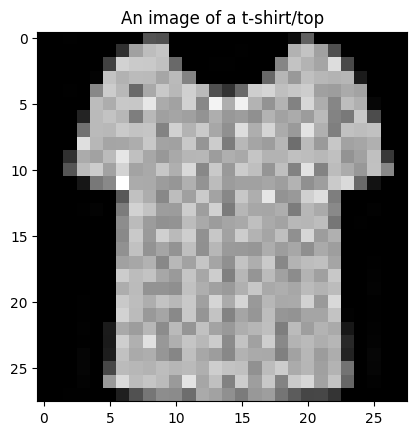


Top predictions:

           shirt: 52.42%
     t-shirt/top: 47.58%
           dress: 0.00%
        pullover: 0.00%
          sandal: 0.00%


In [21]:
model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers,
).to(device)
model.load_state_dict(torch.load("clip.pt", map_location=device))

class_names = [
    "t-shirt/top",
    "trousers",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = (
    mask.repeat(1, len(mask[0]))
    .reshape(len(mask), len(mask[0]), len(mask[0]))
    .to(device)
)

idx = 1000

img = test_set[idx]["image"][None, :]
plt.imshow(img[0].permute(1, 2, 0), cmap="gray")
plt.title(
    tokenizer(test_set[idx]["caption"], encode=False, mask=test_set[idx]["mask"][0])[0]
)
plt.show()
img = img.to(device)
with torch.no_grad():
    image_features = model.image_encoder(img)
    text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")

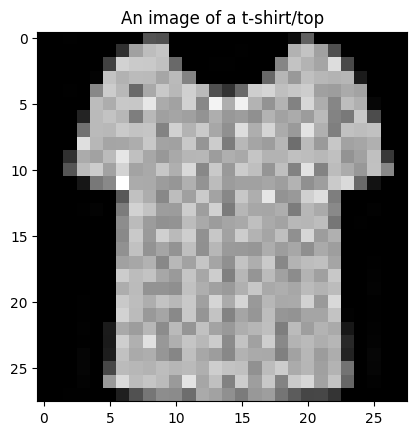


Top predictions for idx 1000:

           shirt: 52.42%
     t-shirt/top: 47.58%
           dress: 0.00%
        pullover: 0.00%
          sandal: 0.00%


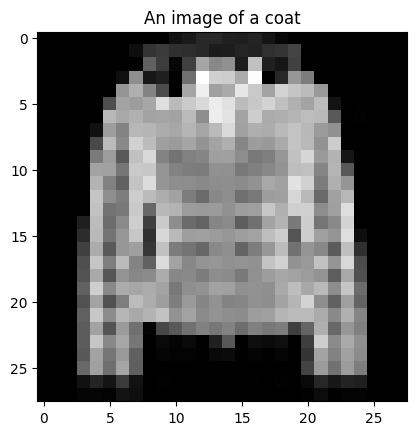


Top predictions for idx 1050:

            coat: 89.18%
           shirt: 9.61%
     t-shirt/top: 1.19%
        pullover: 0.01%
           dress: 0.00%


In [22]:
import torch
import matplotlib.pyplot as plt

# CLIP model ve diğer parametrelerin yüklenmesi
model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers,
).to(device)
model.load_state_dict(torch.load("clip.pt", map_location=device))

# Sınıf isimleri
class_names = [
    "t-shirt/top",
    "trousers",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]

# Metinlerin ve maskelerin hazırlanması
text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = (
    mask.repeat(1, len(mask[0]))
    .reshape(len(mask), len(mask[0]), len(mask[0]))
    .to(device)
)

# İlk tahmin işlemi (idx = 1000)
idx = 1000
img = test_set[idx]["image"][None, :]
plt.imshow(img[0].permute(1, 2, 0), cmap="gray")
plt.title(
    tokenizer(test_set[idx]["caption"], encode=False, mask=test_set[idx]["mask"][0])[0]
)
plt.show()
img = img.to(device)
with torch.no_grad():
    image_features = model.image_encoder(img)
    text_features = model.text_encoder(text, mask=mask)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

print("\nTop predictions for idx 1000:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")

# İkinci tahmin işlemi (idx = 1050)
idx = 1050
img = test_set[idx]["image"][None, :]
plt.imshow(img[0].permute(1, 2, 0), cmap="gray")
plt.title(
    tokenizer(test_set[idx]["caption"], encode=False, mask=test_set[idx]["mask"][0])[0]
)
plt.show()
img = img.to(device)
with torch.no_grad():
    image_features = model.image_encoder(img)
    text_features = model.text_encoder(text, mask=mask)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

print("\nTop predictions for idx 1050:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")
